In [2]:
from scripts import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import seaborn as sns

In [3]:
# load the 2012 data set and look for a day with few measurements
df_2012 = pd.read_csv('data/2012_all_v2.csv')

df_2012

,utc,star,elevation,azimuth,tel_1,tel_2,pop_1,pop_2,cart_1,cart_2,year,month,day,dayofyear
0,2012-02-03T02:25:39.000,#57100,0.713447,2.464114,S1,W1,P4B5,P1B6,87.558149,23.999987,2012,2,3,34
1,2012-02-03T02:25:40.000,#57100,0.713485,2.464196,S1,W1,P4B5,P1B6,87.551523,23.999987,2012,2,3,34
2,2012-02-03T02:25:41.000,#57100,0.713523,2.464278,S1,W1,P4B5,P1B6,87.544909,23.999987,2012,2,3,34
3,2012-02-03T02:46:21.000,#57100,0.757257,2.570060,S1,W1,P4B5,P1B6,78.534254,23.999992,2012,2,3,34
4,2012-02-03T02:46:39.000,#57100,0.757843,2.571662,S1,W1,P4B5,P1B6,78.391951,23.999992,2012,2,3,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22270,2012-12-22T11:46:22.000,#153578,0.929092,0.703750,S1,E1,P1B4,P5B6,6.688514,31.956417,2012,12,22,357
22271,2012-12-22T11:46:22.000,#153578,0.929092,0.703750,S1,W1,P1B4,P3B5,6.688514,0.000000,2012,12,22,357
22272,2012-12-22T11:47:28.000,#153578,0.931664,0.702383,E1,W1,P5B6,P3B5,31.282386,0.000000,2012,12,22,357
22273,2012-12-22T11:47:28.000,#153578,0.931664,0.702383,S1,E1,P1B4,P5B6,6.588786,31.282386,2012,12,22,357


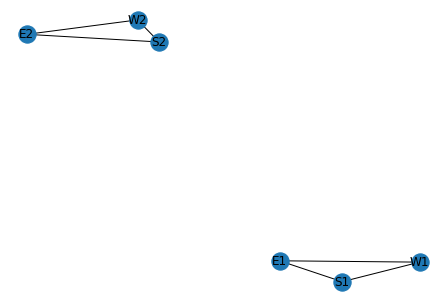

In [5]:
df = df_2012[(df_2012.month == 5) & (df_2012.day == 4)]

graph_df = df.groupby(['tel_1','tel_2']).size().reset_index().rename(columns={0:'count'})
G = nx.from_pandas_edgelist(graph_df, source='tel_1', target='tel_2')

nx.draw(G, with_labels=True)
plt.show()

In [6]:
nx.is_connected(G)

False

In [7]:
# we can see that the graph is disconnected and this is what the function tell us
# lets solve this problem and see if the degeneracies are observable 

design_mat, pinv, y, beta = create_design_mat(df)

In [8]:
beta

array([  67.61217185,  -31.79130762,   -1.02954313,  300.40057979,
         89.61262469,    4.87404459,    4.26467806,  133.96299754,
         -1.20360091,  125.33081666,  305.93213165,   -5.91536702,
        -71.87684991, -102.17168991,    2.23314404,   49.39169636,
          8.18047333,  -46.89531862,  -14.85382856,   -2.49637774,
          6.67335523])

In [9]:
# see that the model is predicting the outcomes well
max(y - design_mat @ beta) 

0.00014834138899288973

In [10]:
# here E2, W2 and S2 are only ever seen together -> and they are not zero'd out 
# expect these to be the ones with strange values
loc_actual = np.array([
    #[0,0,0], # E1
    [194.451, 106.618, - 6.318], # W2
    [300.442, 89.639, 4.954], # W1
    [131.120, 272.382, -6.508], # S2
    [125.371, 305.963, -5.865], # S1
    [54.970, 36.246, -3.077], # E2
])


# so we see that the large errors come for the 1st, 3rd and 5th baselines 
# these correspond to W2, S2 and E2 i.e. disconnected graphs do not perform well!
# but important to remember that the basleines of E2 S2 W2 will still be correct (atleast not really wrong!)
loc_actual.reshape(-1,) - beta[:15]

array([ 1.26838828e+02,  1.38409308e+02, -5.28845687e+00,  4.14202103e-02,
        2.63753079e-02,  7.99554112e-02,  1.26855322e+02,  1.38419002e+02,
       -5.30439909e+00,  4.01833361e-02,  3.08683502e-02,  5.03670226e-02,
        1.26846850e+02,  1.38417690e+02, -5.31014404e+00])

In [11]:
# in the SVD these degeneracies should show themselves as zero singular values 

U, w, Vt = np.linalg.svd(design_mat)

# see that we have 5 zero singular values ad 4 others that are very small
# something in numerical recipes about getting rid of the smaller ones
w

array([1.54374390e+01, 1.35306077e+01, 1.35306077e+01, 1.26915929e+01,
       1.65442388e+00, 1.65442388e+00, 1.54191481e+00, 8.84498233e-01,
       5.73478508e-01, 4.21381312e-01, 4.21381312e-01, 3.37327118e-01,
       8.93053939e-02, 8.93053939e-02, 6.55140054e-02, 4.63610753e-02,
       1.09848269e-15, 7.69188646e-16, 7.14050421e-16, 1.17870290e-16,
       6.57237396e-17])

In [12]:
# looking at the v vectors that correpond to these zero singular values 
# v vectors are the columns of V and are therefore the rows of Vt

Vt[-1] 

array([ 1.16920833e-01, -5.65238206e-01, -8.47978165e-03, -2.99682401e-16,
        1.01543328e-16, -2.15467782e-16,  1.16920833e-01, -5.65238206e-01,
       -8.47978165e-03, -1.34975576e-16, -1.45147341e-16, -2.16471839e-16,
        1.16920833e-01, -5.65238206e-01, -8.47978165e-03, -6.45531842e-04,
       -9.81324089e-03, -6.45531842e-04, -9.81324089e-03, -6.45531842e-04,
       -9.81324089e-03])

In [13]:
np.where(abs(Vt[-1]) > 0.00001)
# this has contributions from W2, S2, E2 and ALL the pop settings
# turns out that it is the same for the rest of them... 

(array([ 0,  1,  2,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 20]),)

In [14]:
V1 = Vt[-1]

V1 = V1[abs(V1) > 0.00001]

# now for the first col we get the values that are significant
V1 / min(abs(V1)) 

# has large values for x and very large values for y componenets

array([ 181.12326188, -875.61630368,  -13.13611675,  181.12326188,
       -875.61630368,  -13.13611675,  181.12326188, -875.61630368,
        -13.13611675,   -1.        ,  -15.20179215,   -1.        ,
        -15.20179215,   -1.        ,  -15.20179215])

In [15]:
V2 = Vt[-2]

V2 = V2[abs(V2) > 0.00001]

# now for the first col we get the values that are significant
V2 / min(abs(V2))

# has very large values for x, large for y 

array([ 1.29393295e+03,  2.69318602e+02, -3.12864863e+01,  1.29393295e+03,
        2.69318602e+02, -3.12864863e+01,  1.29393295e+03,  2.69318602e+02,
       -3.12864863e+01,  1.00000000e+00, -6.89668531e+01,  1.00000000e+00,
       -6.89668531e+01,  1.00000000e+00, -6.89668531e+01])

In [16]:
V3 = Vt[-3]

V3 = V3[abs(V3) > 0.00001]

# now for the first col we get the values that are significant
V3 / min(abs(V3))

# the smallest value here is in the y component
# largest valeus here are z components 
# note that all the baseline vectors and pop settings have the same value here 

array([ 5.63121414, -1.        , 55.38152132,  5.63121414, -1.        ,
       55.38152132,  5.63121414, -1.        , 55.38152132,  2.67542998,
       76.66113355,  2.67542998, 76.66113355,  2.67542998, 76.66113355])

In [17]:
V4 = Vt[-4]

V4 = V4[abs(V4) > 0.00001]

# now for the first col we get the values that are significant
V4 / min(abs(V4))

# again the basline has the same values for all of the the telescopes
# large values for z components comparible with the pop 

array([   2.5283285 ,    1.        , -186.14286938,    2.5283285 ,
          1.        , -186.14286938,    2.5283285 ,    1.        ,
       -186.14286938,  -30.01886177,  135.34826075,  -30.01886177,
        135.34826075,  -30.01886177,  135.34826075])

In [18]:
V5 = Vt[-5]

V5 = V5[abs(V5) > 0.00001]

# now for the first col we get the values that are significant
V5 / min(abs(V5))
# here the z component fo the pop is large and they are all the same 
# though the pop settings is by far the largest

array([-1.98345486e+00, -1.00000000e+00, -3.05606972e+02, -1.98345486e+00,
       -1.00000000e+00, -3.05606972e+02, -1.98345486e+00, -1.00000000e+00,
       -3.05606972e+02,  2.49781592e+03,  1.33736826e+02,  2.49781592e+03,
        1.33736826e+02,  2.49781592e+03,  1.33736826e+02])

In [19]:
# only one POP setting is used for each telescope

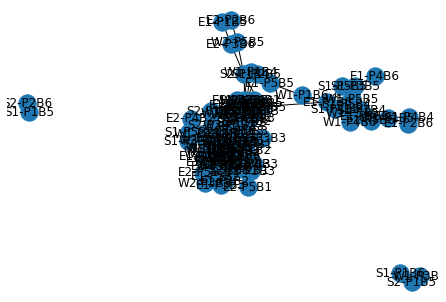

False

In [213]:
df = pd.read_csv('data/2012_all_v2.csv')

df['telpop_1'] = df.tel_1 + '-' + df.pop_1
df['telpop_2'] = df.tel_2 + '-' + df.pop_2

graph_df = df.groupby(['telpop_1','telpop_2']).size().reset_index().rename(columns={0:'count'})
G = nx.from_pandas_edgelist(graph_df, source='telpop_1', target='telpop_2')

nx.draw(G, with_labels=True)
plt.show()
nx.is_connected(G)

In [215]:
design_mat, pinv, y, beta = create_design_mat(df)

U, w, Vt = np.linalg.svd(design_mat)

w

array([9.93756851e+01, 8.82508909e+01, 8.19775483e+01, 7.63647148e+01,
       5.89730366e+01, 4.83388957e+01, 4.58383804e+01, 4.53990512e+01,
       4.47217359e+01, 4.18869259e+01, 3.86254076e+01, 3.80926846e+01,
       3.68385852e+01, 3.58662929e+01, 3.55621065e+01, 3.45387111e+01,
       3.43170385e+01, 3.32772900e+01, 3.22481783e+01, 3.13905033e+01,
       3.02645189e+01, 3.00756075e+01, 2.95862607e+01, 2.86274054e+01,
       2.81007755e+01, 2.76822881e+01, 2.76522563e+01, 2.74964577e+01,
       2.57941656e+01, 2.54872611e+01, 2.50576202e+01, 2.42643976e+01,
       2.38876354e+01, 2.33454731e+01, 2.28962040e+01, 2.21207081e+01,
       2.13834443e+01, 2.13474398e+01, 2.08372713e+01, 2.05008155e+01,
       1.96624907e+01, 1.94221630e+01, 1.86841477e+01, 1.83875189e+01,
       1.80525160e+01, 1.78620278e+01, 1.73263172e+01, 1.70225100e+01,
       1.67118169e+01, 1.64112510e+01, 1.59325854e+01, 1.58581384e+01,
       1.56947420e+01, 1.56707718e+01, 1.54050259e+01, 1.50650370e+01,
      

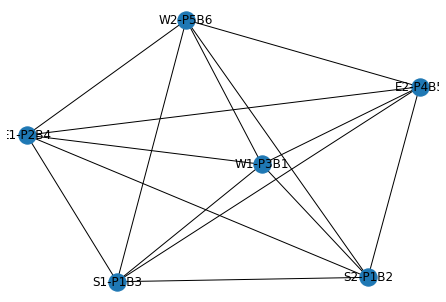

True

In [207]:
df = pd.read_csv('data/2012_all_v2.csv')

df = df[(df.month == 5) & ((df.day == 8))]

df['telpop_1'] = df.tel_1 + '-' + df.pop_1
df['telpop_2'] = df.tel_2 + '-' + df.pop_2

graph_df = df.groupby(['telpop_1','telpop_2']).size().reset_index().rename(columns={0:'count'})
G = nx.from_pandas_edgelist(graph_df, source='telpop_1', target='telpop_2')

nx.draw(G, with_labels=True)
plt.show()

nx.is_connected(G)

In [208]:
design_mat, pinv, y, beta = create_design_mat(df)

beta

array([ 1.28360959e-01, -7.02871008e+00, -2.00417938e+01,  2.84274571e+01,
       -5.23563141e+01,  2.18857432e+01, -7.34654578e+01,  1.33962180e+02,
       -6.05417298e+01, -8.77055166e+01,  1.67178574e+02, -5.07788004e+01,
       -2.93018302e+00,  6.95527943e+00,  2.36572002e+00, -9.69031769e+00,
       -2.11563499e+01, -2.63938574e+00,  2.64041932e+00,  2.57216239e+01,
        5.12401017e+00])

In [209]:
design_mat.shape

(29, 21)

In [210]:
# why are there still singular values when the graph is connected?

U, w, Vt = np.linalg.svd(design_mat)

w

array([4.89830116e+00, 4.89830116e+00, 4.89830116e+00, 4.75576879e+00,
       3.51789347e+00, 8.15214543e-02, 8.15214543e-02, 8.15214543e-02,
       7.82800371e-02, 3.09999122e-02, 8.64692408e-16, 6.35057478e-16,
       4.97166547e-16, 4.18922176e-16, 3.38241444e-16, 1.87636545e-16,
       1.43710779e-16, 1.38430786e-16, 8.88367092e-17, 6.25177640e-17,
       3.04145248e-17])

In [211]:
Vt[-1] / min(abs(Vt[-1]))

array([ 22.55990496,  15.93655725,   7.3585241 , -10.06951929,
        -6.0826334 ,  -1.10886937,  -1.27481742,  -3.84926609,
        -6.64061826,  11.0427636 ,   3.86742427,  -4.70137122,
        -4.04219419,  -2.7045876 ,  -1.        ,  -6.44027383,
       -18.5688146 ,  -3.43010123,   1.12159961,  -3.20444304,
        -4.61894378])

In [124]:
# still get degeneracies as there are less equations than unknowns
design_mat.shape

(29, 21)

In [61]:
df.groupby(['telpop_1','telpop_2']).size().reset_index().rename(columns={0:'count'})

,telpop_1,telpop_2,count
0,E2-P4B5,W1-P3B1,5
1,E2-P4B5,W2-P5B6,5
2,S1-P1B3,E2-P4B5,5
3,S1-P1B3,S2-P1B2,5
4,S1-P1B3,W1-P3B1,5
5,S1-P1B3,W2-P5B6,5
6,S2-P1B2,E2-P4B5,5
7,S2-P1B2,W1-P3B1,5
8,S2-P1B2,W2-P5B6,5
9,W1-P3B1,W2-P5B6,5


# Building a test for degeneracy 

In [103]:
# degeneracy in the pop settings shouldn't be important as we do not want these values
# only the degeneracy in the 

df = pd.read_csv('data/2012_all_v2.csv')
vc = df.dayofyear.value_counts()
trunc_days = df[df.dayofyear.isin(vc.index[vc.values > 350])].dayofyear.value_counts().index

/var/folders/yr/nz2d8_8n42g11zxgd7yjxhq40000gn/T/ipykernel_853/315653599.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['telpop_1'] = df.tel_1 + df.pop_1
/var/folders/yr/nz2d8_8n42g11zxgd7yjxhq40000gn/T/ipykernel_853/315653599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['telpop_2'] = df.tel_2 + df.pop_2


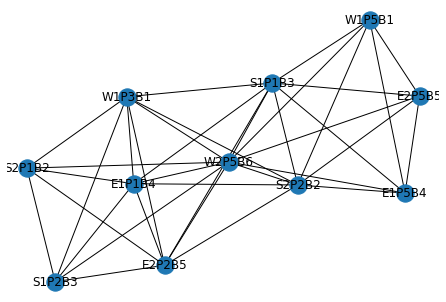

In [108]:
plot_graph(df, 274)

In [182]:
df = pd.read_csv('data/2012_all_v2.csv')

df['telpop_1'] = df.tel_1 + '-' + df.pop_1
df['telpop_2'] = df.tel_2 + '-' + df.pop_2

df_pop_drift = df.groupby(['telpop_1','telpop_2', 'star']).size().reset_index().rename(columns={0:'count'})

df_pop_drift

,telpop_1,telpop_2,star,count
0,E1-P1B1,E2-P2B2,#102763,4
1,E1-P1B1,E2-P2B2,#11068,8
2,E1-P1B1,E2-P2B2,#1470,12
3,E1-P1B1,E2-P2B2,#153578,2
4,E1-P1B1,E2-P2B2,#158486,7
...,...,...,...,...
3264,W1-P4B3,W2-P5B1,#286136,1
3265,W1-P4B3,W2-P5B1,#301163,2
3266,W1-P4B3,W2-P5B1,#306258,1
3267,W1-P5B1,W2-P5B6,#17622,2


In [191]:
# find the location for 66 
most_common = np.max(df_pop_drift['count'])

np.where(df_pop_drift['count'] == 56)

(array([2599]),)

In [196]:
df_pop_drift.loc[np.where(df_pop_drift['count'] == 56)].telpop_1.values

array(['S2-P1B5'], dtype=object)

In [202]:
combinations = []

for count in set(df_pop_drift['count']):

    combination = df_pop_drift.loc[np.where(df_pop_drift['count'] == count)]

    df = pd.read_csv('data/2012_all_v2.csv')

    df['telpop_1'] = df.tel_1 + '-' + df.pop_1
    df['telpop_2'] = df.tel_2 + '-' + df.pop_2

    df = df[(df.telpop_1 == combination.telpop_1.values[0]) & (df.telpop_2 == combination.telpop_2.values[0]) & (df.star == combination.star.values[0])]

    combinations.append(set(df.dayofyear))
    
combinations

[{181},
 {141},
 {302},
 {303},
 {317},
 {108},
 {141},
 {301, 302},
 {331},
 {108},
 {265, 266},
 {238, 239},
 {113},
 {180},
 {181},
 {181},
 {239},
 {141, 142},
 {232},
 {181},
 {180, 181},
 {357},
 {181},
 {257, 258, 319},
 {180, 181},
 {332, 333},
 {190, 215},
 {276, 283, 290, 291},
 {257, 258},
 {317, 319},
 {332, 333},
 {257, 258},
 {180, 181},
 {228, 229},
 {257, 258},
 {307, 308, 309},
 {220, 221},
 {153, 154},
 {180, 181},
 {215, 260},
 {182, 183},
 {111, 112},
 {257, 258, 319},
 {257, 258},
 {219, 220},
 {186, 187, 189},
 {232, 233},
 {276, 283, 290, 291},
 {257, 258},
 {219, 220},
 {219, 220, 221}]

In [ ]:
most_common = np.max(df_pop_drift['count'])

np.where(df_pop_drift['count'] == most_common)

In [217]:
combination = df_pop_drift.loc[np.where(df_pop_drift['count'] == 51)]

df = pd.read_csv('data/2012_all_v2.csv')

df['telpop_1'] = df.tel_1 + '-' + df.pop_1
df['telpop_2'] = df.tel_2 + '-' + df.pop_2

df = df[(df.telpop_1 == combination.telpop_1.values[0]) & (df.telpop_2 == combination.telpop_2.values[0]) & (df.star == combination.star.values[0])]

df

,utc,star,elevation,azimuth,tel_1,tel_2,pop_1,pop_2,cart_1,cart_2,year,month,day,dayofyear,telpop_1,telpop_2
15782,2012-10-02T03:49:03.000,#266328,1.415455,4.880142,E1,W1,P1B2,P5B3,57.999981,13.380892,2012,10,2,276,E1-P1B2,W1-P5B3
15785,2012-10-02T03:50:05.000,#266328,1.411769,4.878763,E1,W1,P1B2,P5B3,57.999981,14.437785,2012,10,2,276,E1-P1B2,W1-P5B3
15788,2012-10-02T03:51:42.000,#266328,1.406001,4.876846,E1,W1,P1B2,P5B3,57.999981,16.087819,2012,10,2,276,E1-P1B2,W1-P5B3
15791,2012-10-02T03:52:14.000,#266328,1.404097,4.876273,E1,W1,P1B2,P5B3,57.999981,16.631221,2012,10,2,276,E1-P1B2,W1-P5B3
15806,2012-10-02T04:23:52.000,#266328,1.291094,4.872739,E1,W1,P1B2,P5B3,57.999981,47.920718,2012,10,2,276,E1-P1B2,W1-P5B3
15809,2012-10-02T04:23:53.000,#266328,1.291034,4.872747,E1,W1,P1B2,P5B3,57.999981,47.936662,2012,10,2,276,E1-P1B2,W1-P5B3
15812,2012-10-02T04:23:56.000,#266328,1.290855,4.872769,E1,W1,P1B2,P5B3,57.999981,47.984495,2012,10,2,276,E1-P1B2,W1-P5B3
15815,2012-10-02T04:24:51.000,#266328,1.287582,4.873192,E1,W1,P1B2,P5B3,57.999981,48.860302,2012,10,2,276,E1-P1B2,W1-P5B3
15830,2012-10-02T05:01:04.000,#266328,1.158520,4.899761,E1,W1,P1B2,P5B3,57.999981,81.796770,2012,10,2,276,E1-P1B2,W1-P5B3
15833,2012-10-02T05:01:05.000,#266328,1.158461,4.899776,E1,W1,P1B2,P5B3,57.999981,81.811113,2012,10,2,276,E1-P1B2,W1-P5B3


In [218]:
np.linalg.matrix_rank(design_mat)

118

In [231]:
df = pd.read_csv('data/2019_04_07.csv')

design_mat = create_design_mat(df)[0]

%timeit np.linalg.svd(design_mat)

224 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
actual_locations_2005

array([[194.451, 106.618,  -6.318],
       [300.442,  89.639,   4.954],
       [131.12 , 272.382,  -6.508],
       [125.371, 305.963,  -5.865],
       [ 54.97 ,  36.246,  -3.077]])

In [5]:
beta

NameError: name 'beta' is not defined